In [ ]:
!pip install seaborn scikit-learn tensorflow pooch -q

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, datasets
# from tensorflow.keras.layers import preprocessing

from sklearn.metrics import classification_report

%matplotlib inline
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = "tight"
# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

2024-11-19 18:02:03.985329: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732039324.342524 4115680 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732039324.448689 4115680 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 18:02:05.343169: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Image as data
Sofar we've seen that everytime we work with ML models, we need to have the input data as vectors. There’s almost no ML model where vectors aren’t used at some point in the project lifecycle. Machines can’t read text or look at images like you and me. They need input to be transformed or encoded into numbers. 

Please be aware that the a strictly mathematical definition of vectors can fail to convey all the information you need to work with and understand vectors in an ML context like this:

<img src="img/lab_10_img_as_data_.png"/>

so for MNIST data, we turned a (28, 28) image to a vector of size (748,).

An image is nothing but a matrix of pixel values. In last session, we just flattened them in order to train a sequential NN on them.

Number of original training examples: 60000
Number of original test examples: 10000


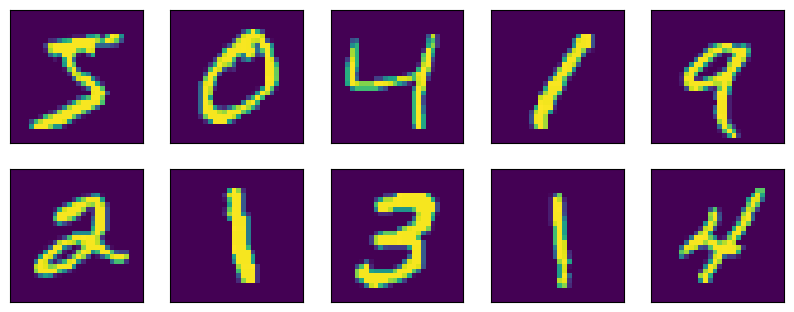

In [2]:
(x_train, y_train),(x_test, y_test) = datasets.mnist.load_data()

# rescale the images from [0, 255] to the [0.0, 0.1] range
x_train, x_test = x_train / 255.0, x_test / 255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

# check the first 10 examples
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])

plt.show()

In [3]:
x_train[0].shape, x_train[0].flatten().shape

((28, 28), (784,))

In [4]:
x_train[0].shape

(28, 28)

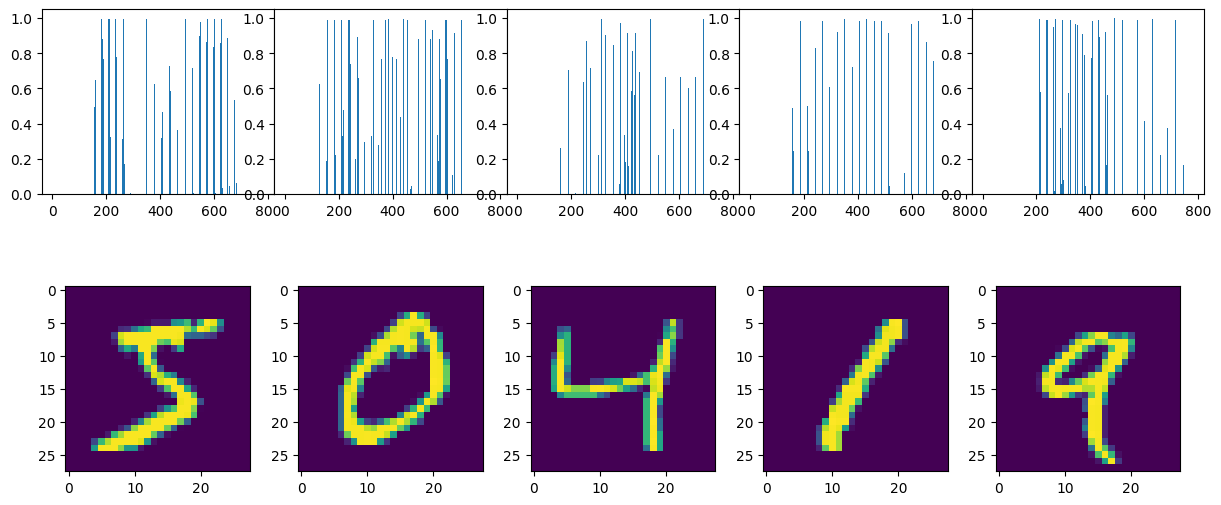

In [5]:
fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

# axs = axs.ravel()

for i in range(5):
    ar = x_train[i].flatten()
    axs[0, i].bar(np.arange(len(ar)), ar)
    axs[1, i].imshow(x_train[i])

# Convolutional Neural Networks



A **Convolutional Neural Network** (ConvNet/CNN) is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other.


The architecture of a ConvNet is analogous to that of the connectivity pattern of Neurons in the Human Brain and was inspired by the organization of the Visual Cortex. Individual neurons respond to stimuli only in a restricted region of the visual field known as the Receptive Field. A collection of such fields overlap to cover the entire visual area.

## Why CNN as oppose to sequential models?
You can always feed the flatten images to a sequential model, however a ConvNet is able to **successfully capture the Spatial and Temporal dependencies** in an image through the application of relevant filters. 

In the figure, we have an RGB image which has been separated by its three color planes — Red, Green, and Blue.

<img src="img/lab_10_rgb.png"/>

You can imagine how computationally intensive things would get once the images reach dimensions, say 8K (7680×4320). The role of the ConvNet is to reduce the images into a form which is easier to process, without losing features which are critical for getting a good prediction. This is important when we are to design an architecture which is not only good at learning features but also is scalable to massive datasets.

The architecture performs a better fitting to the image dataset due to the reduction in the number of parameters involved and reusability of weights. In other words, the network can be trained to understand the sophistication of the image better.


## Convolution Layer

In [6]:
from IPython.display import Image
Image(url="https://miro.medium.com/max/1000/1*GcI7G-JLAQiEoCON7xFbhg.gif")

**local receptive fields**: In a typical neural network, each neuron in the input layer is connected to a neuron in the hidden layer. However, in a CNN, only a small region of input layer neurons connects to neurons in the hidden layer. These regions are referred to as **local receptive fields**. You can use **Convolusion** to implement this process efficiently. 

The element involved in carrying out the convolution operation in the first part of a Convolutional Layer is called the **Kernel/Filter**, K, represented in the color yellow. We have selected K as a 3x3x1 matrix.


The Kernel shifts 9 times because of **Stride Length** = 1 (Non-Strided), every time performing a matrix multiplication operation between K and the portion P of the image over which the kernel is hovering.

The objective of the Convolution Operation is to extract the high-level features such as edges, from the input image. 

ConvNets need not be limited to only one Convolutional Layer. 

The first ConvLayer is responsible for capturing the Low-Level features such as edges, color, gradient orientation, etc. With added layers, the architecture adapts to the High-Level features as well, giving us a network which has the wholesome understanding of images in the dataset, similar to how we would.

In [7]:
import scipy
import numpy as np
import matplotlib.pyplot as plt


The **ascent** image is a classic grayscale test image provided by the scipy library, often used in image processing and computer vision tasks. It’s a 2D array of pixel intensity values (with shape 512x512), representing a well-known black-and-white photograph. 

In [8]:
# load 'ascent' image from scipy
i = scipy.datasets.ascent()

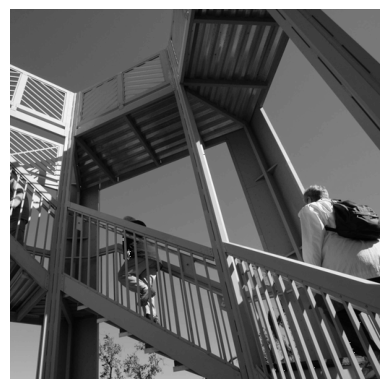

In [9]:
plt.grid(False)
plt.gray()
plt.axis('off')
plt.imshow(i)
plt.show()

In [10]:
i_transformed = np.copy(i)
# Get the dimensions of the image to loop over it later
size_x = i_transformed.shape[0]
size_y = i_transformed.shape[1]

In [11]:
# create a 3x3 filter

# Experiment with different values for fun effects.
filter = [ [-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]
filter = [ [1, 0, 0], [0, 1, 0], [0, 0, 1]]
# filter = [ [0, 0, 1], [0, 1, 0], [1, 0, 0]]


weight  = 1


In [12]:
# let's creata convolution. Notice in the code, you iterate over the image, 
# leaving a 1 pixel margin, and multiply out each of the neighbors of the current pixel
#  by the value defined in the filter.

for x in range(1,size_x-1):
  for y in range(1,size_y-1):
      convolution = 0.0
      convolution = convolution + (i[x - 1, y-1] * filter[0][0])
      convolution = convolution + (i[x, y-1] * filter[0][1])
      convolution = convolution + (i[x + 1, y-1] * filter[0][2])
      convolution = convolution + (i[x-1, y] * filter[1][0])
      convolution = convolution + (i[x, y] * filter[1][1])
      convolution = convolution + (i[x+1, y] * filter[1][2])
      convolution = convolution + (i[x-1, y+1] * filter[2][0])
      convolution = convolution + (i[x, y+1] * filter[2][1])
      convolution = convolution + (i[x+1, y+1] * filter[2][2])
      convolution = convolution * weight
      if(convolution<0):
        convolution=0
      if(convolution>255):
        convolution=255
      i_transformed[x, y] = convolution

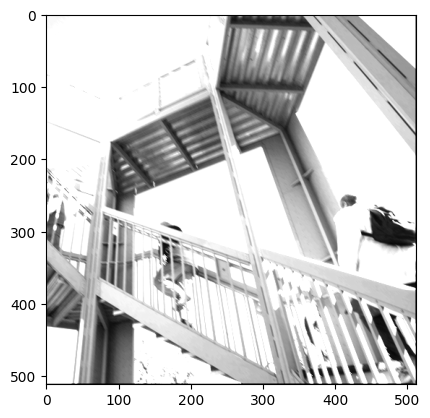

In [13]:
# Plot the image. Note the size of the axes -- they are 512 by 512
plt.gray()
plt.grid(False)
plt.imshow(i_transformed)
#plt.axis('off')
plt.show()


### Pooling Layer

Similar to the Convolutional Layer, the Pooling layer is responsible for reducing the overall amount of information in an image while maintaining the features that are detected as present.



Pooling reduces the dimensionality of the featured map by condensing the output of small regions of neurons into a single output. This helps simplify the following layers and reduces the number of parameters that the model needs to learn.



There are two common types of Pooling: Max Pooling and Average Pooling. Max Pooling returns the maximum value from the portion of the image covered by the Kernel. On the other hand, Average Pooling returns the average of all the values from the portion of the image covered by the Kernel.

In [14]:
Image(url="https://miro.medium.com/max/792/1*uoWYsCV5vBU8SHFPAPao-w.gif")

## Putting it all together

After going through the above process (kernel and max pooling), we have successfully enabled the model to understand the features. Moving on, we are going to flatten the final output and feed it to a regular Neural Network for classification purposes.

Adding a Fully-Connected layer is a (usually) cheap way of learning non-linear combinations of the high-level features as represented by the output of the convolutional layer. The Fully-Connected layer is learning a possibly non-linear function in that space.


Now that we have converted our input image into a suitable form for our Multi-Level Perceptron, we flatten the image into a column vector. The flattened output is fed to a feed-forward neural network and backpropagation applied to every iteration of training. Over a series of epochs, the model is able to distinguish between dominating and certain low-level features in images and classify them using the Softmax Classification technique.

<img src="img/lab_10_cnn_2.png"/>

To summarize, A convolution is a filter that passes over an image, processes it, and extracts features that show a commonality in the image.

The process is simple. You scan every pixel in the image and then look at its neighboring pixels. You multiply out the values of these pixels by equivalent weights in a filter.

<img src="img/lab_10_cnn.png"/>


# Classify MNIST data using CNNs

In [15]:
x_train[0].shape

(28, 28)

In [16]:
# reshape dataset to have a single channel
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

In [17]:
x_test.shape

(10000, 28, 28, 1)

In [18]:
# one-hot encode target values
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

Neural networks, unlike Random Forests, typically require the target labels to be in a one-hot encoded format, especially if you're using categorical cross-entropy as the loss function.

In [19]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

# Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of Conv2D and MaxPooling2D layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (28, 28, 1). You can do this by passing the argument input_shape to your first layer.

In [20]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

/usr/local/google/home/amirimani/Desktop/projects/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-19 18:02:23.779922: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [21]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2))
])

* Conv2D: This specifies a 2D convolutional layer, which is suitable for processing 2D spatial data like images. Each convolutional layer learns filters (also called kernels) that slide over the input image to detect specific features (e.g., edges, shapes) at different locations.

* 32: This number defines the number of filters in the layer. Each filter learns a unique feature in the input, so setting this to 32 means that this layer will learn 32 distinct features. The output of this layer will have 32 channels (or depth of 32), corresponding to each filter’s output.

* (3, 3): This tuple specifies the size of each filter (also known as the kernel size). Here, each filter is a 3x3 matrix that will slide over the input, performing convolutions. Smaller filters (like 3x3) are commonly used as they capture local patterns while keeping the computational load manageable.

In [22]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,568 (37.38 KB)

 Trainable params: 9,568 (37.38 KB)

 Non-trainable params: 0 (0.00 B)

you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically, as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

----

To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D, then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

In [23]:

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [24]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       102,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,386 (442.91 KB)

 Trainable params: 113,386 (442.91 KB)

 Non-trainable params: 0 (0.00 B)

# Compile and train the model

In [25]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',
              tf.keras.metrics.F1Score(average='macro')])

history = model.fit(x_train, y_train, epochs=10, 
                    validation_split=0.2)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.8862 - f1_score: 0.8843 - loss: 0.3724 - val_accuracy: 0.9809 - val_f1_score: 0.9808 - val_loss: 0.0656
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9839 - f1_score: 0.9838 - loss: 0.0521 - val_accuracy: 0.9874 - val_f1_score: 0.9873 - val_loss: 0.0443
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9887 - f1_score: 0.9886 - loss: 0.0338 - val_accuracy: 0.9841 - val_f1_score: 0.9840 - val_loss: 0.0516
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.9917 - f1_score: 0.9917 - loss: 0.0252 - val_accuracy: 0.9861 - val_f1_score: 0.9860 - val_loss: 0.0477
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9943 - f1_score: 0.9942 - loss: 0.0182 - val_accuracy: 0.9902 - val_f1_score: 0.9901 - val_loss: 0.0346
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9955 - f1_score: 0.9954 - loss: 0.0148 - val_accuracy: 0.9898 - 

# Evaluate the model

313/313 - 2s - 5ms/step - accuracy: 0.9854 - f1_score: 0.9852 - loss: 0.0623


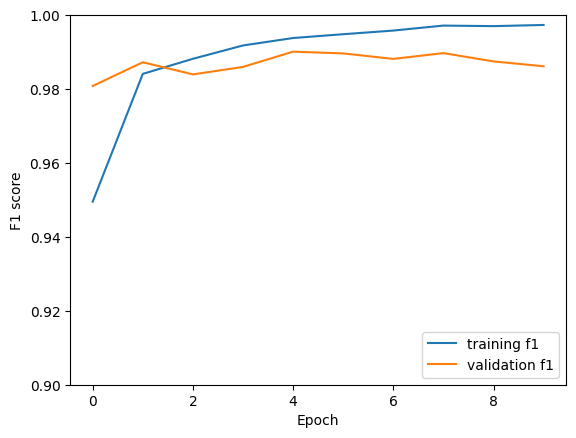

In [26]:
plt.plot(history.history['f1_score'], label='training f1')
plt.plot(history.history['val_f1_score'], label = 'validation f1')
plt.xlabel('Epoch')
plt.ylabel('F1 score')
plt.ylim([0.9, 1])
plt.legend(loc='lower right')

test_loss, test_acc, test_f1 = model.evaluate(x_test, y_test, verbose=2)

313/313 - 1s - 4ms/step - accuracy: 0.9854 - f1_score: 0.9852 - loss: 0.0623


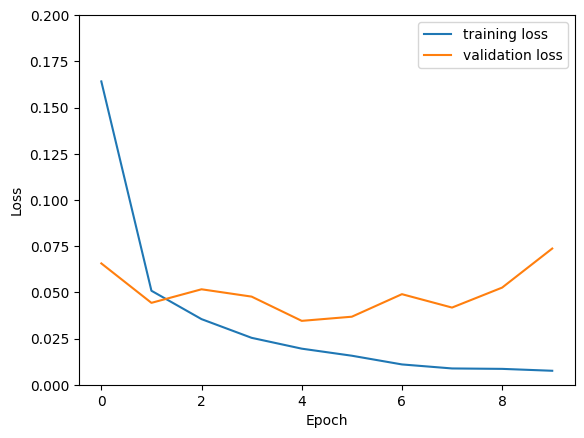

In [27]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 0.2])
plt.legend(loc='upper right')

test_loss, test_acc, test_f1 = model.evaluate(x_test, y_test, verbose=2)

please note that the validation loss is somewhat increasing while the training loss is decreasing. This is a case of overfitting. The training loss will always tend to improve as training continues up until the model's capacity to learn has been saturated. When training loss decreases but validation loss increases, your model has reached the point where it has stopped learning the general problem and started learning the data.

Some approaches to adddress overfitting (could be extended to sequential NNs too):
* **Data Augmentation**:
    - Expand your dataset: Artificially increase the size and diversity of your training data by applying transformations like:
    - Rotation: Rotate images by various angles.   
    - Flipping: Flip images horizontally or vertically.   
    - Scaling: Resize images.   
    - Cropping: Randomly crop different sections of images.
* **Data Batch Sizes**:
    - Smaller batch sizes: Smaller batch sizes introduce variability in training, acting as regularization to prevent overfitting
* **Model Config**:
    - Dropout: add neuron dropouts on random
    - Regularization: In most deep learning frameworks, such as TensorFlow, you can add regularization directly when defining layers or the optimizer
    - Batch Normalization: Normalizes the activations of each layer within a mini-batch
    - Early Stopping: top training when the validation performance starts to decrease
    - Learning Rate: use decaying learning rate
* **Model Complexity**:
    - Reduce Model Complexity: simplify your architecture, reduce number of layers, using fewer filters in ConvNet

   


In [28]:
y_pred = model.predict(x_test, batch_size=64, 
                               verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_test, axis=1), y_pred_bool))

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       980
           1       0.99      1.00      0.99      1135
           2       1.00      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.97      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.99      0.98      0.98       974
           9       0.99      0.96      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



# Batch Normalization

Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This normalization step is applied right before (or right after) the nonlinear function.

This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.


* Deep neural networks are challenging to train, not least because the input from prior layers can change after weight updates.
* Batch normalization is a technique to standardize the inputs to a network, applied to either the activations of a prior layer or inputs directly.
* Batch normalization accelerates training, in some cases by halving the epochs or better, and provides some regularization, reducing generalization error.

In [33]:
from tensorflow.keras.layers import  BatchNormalization

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')   
])


model.summary()

/usr/local/google/home/amirimani/Desktop/projects/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       102,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,642 (443.91 KB)

 Trainable params: 113,514 (443.41 KB)

 Non-trainable params: 128 (512.00 B)

In [38]:
# Compile and train the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.F1Score(average='macro')])


historybn = model.fit(x_train, y_train, epochs=10, 
                      validation_split=0.2)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.9948 - f1_score: 0.9948 - loss: 0.0170 - val_accuracy: 0.9868 - val_f1_score: 0.9866 - val_loss: 0.0580
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9957 - f1_score: 0.9956 - loss: 0.0126 - val_accuracy: 0.9863 - val_f1_score: 0.9862 - val_loss: 0.0671
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.9956 - f1_score: 0.9955 - loss: 0.0125 - val_accuracy: 0.9897 - val_f1_score: 0.9896 - val_loss: 0.0543
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9970 - f1_score: 0.9970 - loss: 0.0096 - val_accuracy: 0.9887 - val_f1_score: 0.9885 - val_loss: 0.0622
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9968 - f1_score: 0.9968 - loss: 0.0090 - val_accuracy: 0.9893 - val_f1_score: 0.9892 - val_loss: 0.0511
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9973 - f1_score: 0.9973 - loss: 0.0083 - val_accuracy: 0.989

313/313 - 2s - 5ms/step - accuracy: 0.9895 - f1_score: 0.9894 - loss: 0.0512


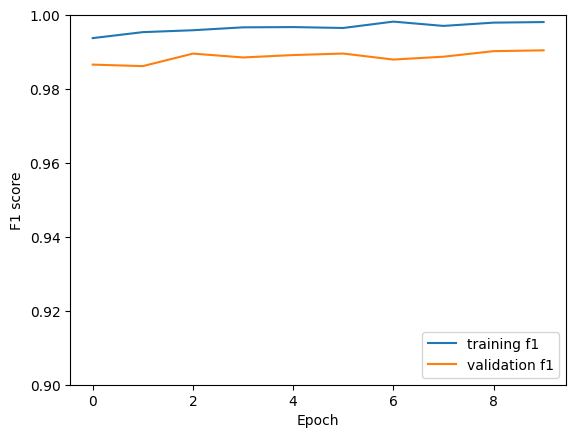

In [39]:
plt.plot(historybn.history['f1_score'], label='training f1')
plt.plot(historybn.history['val_f1_score'], label = 'validation f1')
plt.xlabel('Epoch')
plt.ylabel('F1 score')
plt.ylim([0.9, 1])
plt.legend(loc='lower right')

test_loss, test_acc, test_f1 = model.evaluate(x_test, y_test, verbose=2)

313/313 - 1s - 4ms/step - accuracy: 0.9895 - f1_score: 0.9894 - loss: 0.0512


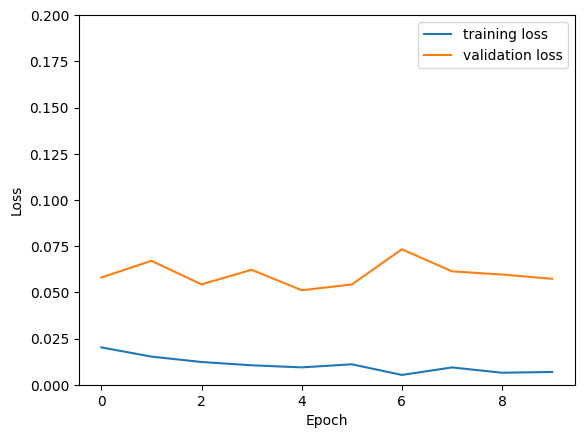

In [40]:
plt.plot(historybn.history['loss'], label='training loss')
plt.plot(historybn.history['val_loss'], label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 0.2])
plt.legend(loc='upper right')

test_loss, test_acc, test_f1 = model.evaluate(x_test, y_test, verbose=2)

In [37]:
y_pred = model.predict(x_test, batch_size=64, 
                               verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_test, axis=1), y_pred_bool))

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.98      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.95      1.00      0.97       892
           6       0.99      0.98      0.98       958
           7       1.00      0.98      0.99      1028
           8       0.99      0.98      0.99       974
           9       0.98      0.99      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



# Visualize layers


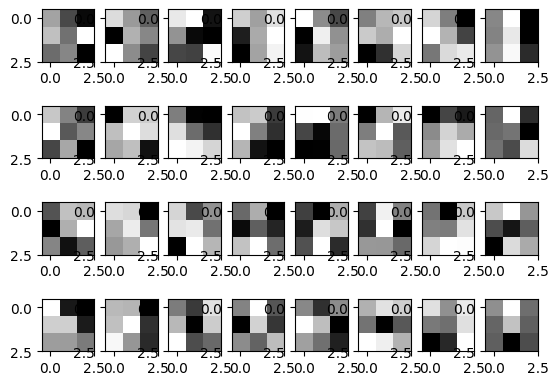

In [43]:
layer_1 = model.layers[0]
weights, biases = layer_1.get_weights()
fig, axes = plt.subplots(4, 8)
for ax, weight in zip(axes.ravel(), weights.T):
    ax.imshow(weight[0, :, :])


In [59]:
example_image = x_train[0:1] 

In [62]:
conv_output = tf.nn.conv2d(example_image, weights, strides=[1, 1, 1, 1], padding='SAME')
conv_output = conv_output + biases


# Apply ReLU activation
conv_output = tf.nn.relu(conv_output)

# Now apply MaxPooling (2x2)
pooling_layer = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='SAME')

# Apply max pooling
pool_output = pooling_layer(conv_output)

# Convert the tensor to numpy for visualization
pool_output_np = pool_output.numpy()

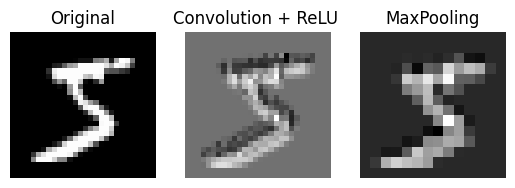

In [65]:
# Plot the original image
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(example_image[0, :, :, 0])
plt.axis("off")

# Plot the convolution output (after ReLU activation)
plt.subplot(1, 3, 2)
plt.title("Convolution + ReLU ")
plt.imshow(conv_output[0, :, :, 0])
plt.axis("off")

# Plot the output after MaxPooling
plt.subplot(1, 3, 3)
plt.title("MaxPooling")
plt.imshow(pool_output_np[0, :, :, 0])
plt.axis("off")

plt.show()

There are various architectures of CNNs available. Some of them have been listed below:

* AlexNet (5 convolutional layers, 3 max-pooling layers, 2 normalization layers, 2 fully connected layers, and 1 softmax layer)
* VGGNet (up to 19 layers)
* GoogLeNet (22 layers deep, with 27 pooling layers included)
* ResNet (34, 50, 101)